# PREMIER CYCLE

In [96]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import tree
from sklearn.metrics import confusion_matrix, classification_report, auc, roc_curve, matthews_corrcoef
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import scipy.stats as stat

Dans ce premier cycle, nous utiliserons le fichier de données data_V1.csv, soit celui pour lequel les valeurs manquantes "?" ont été recodées ou regroupées avec d'autres modalités.

Nous allons dans un premier temps définir les fonctions que nous utiliserons ensuite pour créer les modèles Logit et Arbre de décision (l'entièreté du code dans models.py):

    - Create_Train_Test : crée les jeu d'entraînement et de test en dummies.
    - Logistic_Regression : crée et entraine le model Logit sur les données d'entraînement.
    - DecisionTree : crée et entraine le model Arbre de décision sur les données d'entraînement.
    - ROC : Calcule et affiche la courbe en ROC et retourne l'AUC de cette courbe ROC.
    - gAUC : Calcule le gAUC pour une variable qualitative passée en argument.
    - Evaluation : Évalue les modèles en calculant les métriques de qualités
    - Scoring : Donne un score de qualité aux modèles en fonction des valeurs cibles des métriques de qualité.

In [97]:
def Create_Train_Test(df):
    """
    Créer les dataframes de test et d'entraînement 
    """
    y = df.pop('income')
    y = pd.get_dummies(y)['>50K']
    X = pd.get_dummies(df)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=0, stratify=y)

    return X_train, X_test, y_train, y_test

In [99]:
def Logistic_Regression(X_train, y_train):
    """
    Crée le Logit et l'entraîne grâce aux datasets d'entraînement
    """
    model = LogisticRegression(random_state = 42).fit(X_train, y_train)

    return model

def DecisionTree(X_train, y_train):
    """
    Créer l'arbre de décision et l'entraîne grâce aux datasets d'entraînement
    """
    model = tree.DecisionTreeClassifier(random_state = 42).fit(X_train, y_train)

    return model

In [100]:
def ROC(model, X_test, y_test):
    """
    Calcule la courbe ROC du modèle et retourne l'AUC
    """
    FER, TER, threshold = roc_curve(y_test, model.predict_proba(X_test)[:,1])
    AUC = auc(FER,TER)

    ### ROC ####
    plt.figure()
    plt.plot(FER, TER)
    plt.annotate(f'AUC:{round(AUC, 3)}', (0.7,0.3))
    plt.title('Courbe ROC et AUC')
    plt.grid()
    plt.show()
    
    return AUC

In [101]:
def gAUC(model, X_test, y_test, var):
    """
    Calcule le gAUC pour une variable qualitative passée en argument
    """
    X_test.reset_index(inplace=True, drop=True)
    y_test.reset_index(inplace=True, drop=True)
    df_var = X_test.filter(regex=f"^{var}")
    
    auc_liste = []

    for col in df_var:
        X_auc = X_test.loc[df_var[col]==True]
        y_auc = y_test.iloc[X_auc.index]
        if len(y_auc.unique())!=2:
            continue
        else :
            y_prob = model.predict_proba(X_auc)[:,1]

            col_FER, col_TER, threshold = roc_curve(y_auc, y_prob)
            AUC = auc(col_FER,col_TER)
            auc_liste.append(AUC)
    gAUC = np.mean(auc_liste)
    return gAUC

In [ ]:
def Evaluation(model, X_test, y_test, isLogit):
    """
    Affiche les résultats du modèle avec les datasets de test
    Différenciation entre Logit et arbre de décision
    """
    predict_Y = model.predict(X_test)
    names = model.feature_names_in_
    if isLogit:
        print('Intercept', model.intercept_)
        df_coefficents = pd.DataFrame({'Variables':names,
                                    'Coefficients':model.coef_[0],
                                    'Odd-Ratios':np.exp(model.coef_[0])})
        print(df_coefficents.sort_values(by="Odd-Ratios", ascending=False)[:10].to_string())
    else:
        df_importance = pd.DataFrame({'Variables':names,
                                      'Importance':model.feature_importances_}).sort_values(by='Importance',
                                                                                            ascending=False, ignore_index=True)
        print(df_importance.loc[df_importance['Importance']!=0][:10].to_string())
        tree.plot_tree(model, feature_names= list(X_test.columns), filled=True)
        plt.show()
    print('Matrice de confusion:')
    print(confusion_matrix(y_test, predict_Y))
    Accuracy = model.score(X_test,y_test)
    class_report = classification_report(y_test, predict_Y, output_dict=True)
    class_report = pd.DataFrame(class_report)
    # print(class_report.to_string())
    f1_score = class_report.loc['f1-score']['accuracy']
    MCC = matthews_corrcoef(y_test, predict_Y)
    AUC = ROC(model, X_test, y_test)

    #Calcul du gAUC moyen
    gAUC_liste = []
    for var in df_V1.select_dtypes(include='object').columns:
        gauc = gAUC(model, X_test, y_test, var)
        gAUC_liste.append(gauc)
    gauc = np.mean(gAUC_liste)

    df_metrics = pd.DataFrame({'Valeur':[AUC, f1_score, Accuracy, MCC, gauc],
                               'Cible':[0.8, 0.75, 0.85, 0.75, 0.8]},
                               index = ['AUC', 'F1-Score', 'Accuracy', 'MCC', 'gAUC'])
    return df_metrics

In [103]:
def Scoring(df_metrics, isLogit):
    """
    Calcul le score du modèle en fonction des métriques de df_metrics
    """
    if isLogit:
        model_name = 'Logit'
    else:
        model_name = 'Tree'

    print(f"#### SCORING {model_name.upper()} ####")
    print(df_metrics.to_string())
    score = df_metrics.apply(lambda row : 1 if row['Valeur'] > row['Cible'] else 0, axis=1).sum()
    print(f'Score du {model_name}:', score)
    return df_metrics, score

Nous pouvons désormais construire le modèle de régression logistique à partir des fonctions définies.

/Users/alexanderlunel/Documents/LILLE/Master/MasterSIAD/M2/Scoring/Etude de cas/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Intercept [-0.79540434]
                            Variables  Coefficients  Odd-Ratios
31  marital-status_Married-civ-spouse      0.764558    2.148046
39         occupation_Exec-managerial      0.619385    1.857785
45          occupation_Prof-specialty      0.569795    1.767905
22                education_Bachelors      0.535549    1.708386
55                  relationship_Wife      0.408135    1.504010
25                  education_Masters      0.388089    1.474161
50               relationship_Husband      0.386735    1.472166
27              education_Prof-school      0.180931    1.198333
9              workclass_Self-emp-inc      0.148085    1.159611
23                education_Doctorate      0.143097    1.153842
Matrice de confusion:
[[6958  473]
 [1085 1253]]


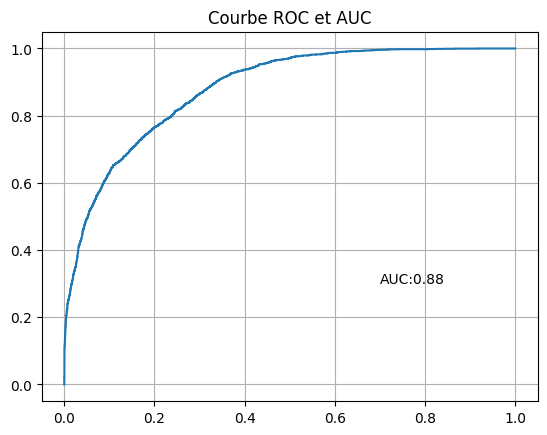

#### SCORING LOGIT ####
            Valeur  Cible
AUC       0.880442   0.80
F1-Score  0.840516   0.75
Accuracy  0.840516   0.85
MCC       0.528338   0.75
gAUC      0.844628   0.80
Score du Logit: 3


In [104]:
#####  LOGIT   #####
df_V1 = pd.read_csv('files/data/data_V1.csv')
X_train, X_test, y_train, y_test = Create_Train_Test(df_V1)
model_logit = Logistic_Regression(X_train, y_train)
df_metrics_logit = Evaluation(model_logit, X_test, y_test, True)
df_metrics_logit, score = Scoring(df_metrics_logit, True)

Nous construisons l'Arbre de décision.

                            Variables  Importance
0   marital-status_Married-civ-spouse    0.217490
1                                 age    0.169260
2                        capital-gain    0.134414
3                      hours-per-week    0.097180
4                        capital-loss    0.062174
..                                ...         ...
94                native-country_Laos    0.000071
95  native-country_Dominican-Republic    0.000053
96           native-country_Nicaragua    0.000039
97              workclass_Without-pay    0.000028
98         occupation_Priv-house-serv    0.000021

[99 rows x 2 columns]


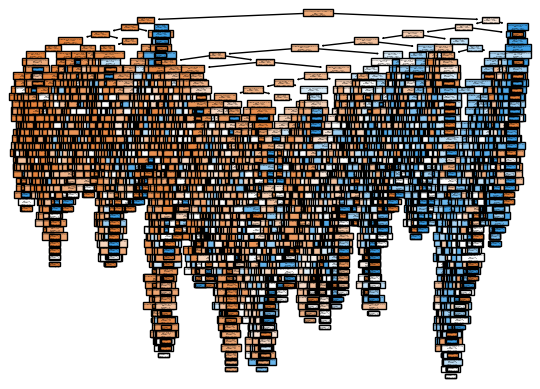

Matrice de confusion:
[[6599  832]
 [ 918 1420]]


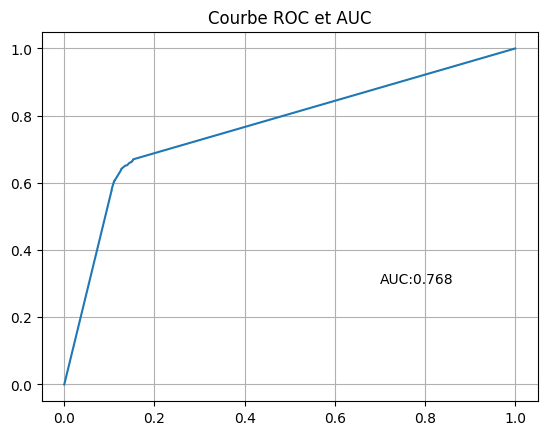

#### SCORING TREE ####
            Valeur  Cible
AUC       0.768180   0.80
F1-Score  0.820862   0.75
Accuracy  0.820862   0.85
MCC       0.501868   0.75
gAUC      0.721444   0.80
Score du Tree: 1


In [105]:
#####  ARBRE DE DÉCISION   #####
df_V1 = pd.read_csv('files/data/data_V1.csv')
X_train, X_test, y_train, y_test = Create_Train_Test(df_V1)
model_decision_tree = DecisionTree(X_train, y_train)
df_metrics_tree = Evaluation(model_decision_tree, X_test, y_test, False)
df_metrics_tree, score = Scoring(df_metrics_tree, False)